# Homework 1

### Deadline: Monday 24 March 2024 (by 19h00)

### Credits: 20 points

### Instructions:

- When you finish, please submit a single **.ipynb** file via email to wbanda@yachaytech.edu.ec


- The homework is **individual**. Please include your name in the notebook.


- Within a **single python notebook**, solve the following problems.

# Name: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

## 1. Population dynamics (8 points)

The system of ordinary differential equations (ODEs) describing the population dynamics of two prey species ($x$ and $y$) and one predator species ($z$) is given by:


\begin{aligned}
\frac{dx}{dt} &= g_1\,x \left( 1 - \frac{x}{c_1} \right) - p_1\,x\,z, \\
\frac{dy}{dt} &= g_2\,y \left( 1 - \frac{y}{c_2} \right) - p_2\,y\,z, \\
\frac{dz}{dt} &= e_1\,p_1\,x\,z + e_2\,p_2\,y\,z - d\,z.
\end{aligned}


where:

- $g_1$, $g_2$ are the intrinsic growth rates (e.g. birth rates) of the prey populations,

- $c_1$, $c_2$ are the carrying capacities of the prey populations (the carrying capacity of an environment is the maximum population size of a biological species that can be sustained by that specific environment), 
  
- $p_1$, $p_2$ are the predation rates of the predator on each prey (e.g. how successful a hunt is),

- $e_1$, $e_2$ are the conversion efficiencies of consumed prey into predator biomass (the conversion efficiency tells us how efficiently a predator can use the energy from its prey to reproduce),

- $d$ is the natural death rate of the predator. Note that the death rates of the two prey species are intrinsically given by their individual carrying capacities.

This system models the interactions where both prey species grow logistically but are consumed by a common predator.







### State vector and slope:

**(a)** Write down this system of ODEs in terms of the system state vector $S(t)$, i.e. $\frac{dS}{dt} = F(S)$. Identify the slope function $F(S)$ and indicate whether or not it can be explicitly written as a function of $S$. Create a python function for the slope $F(S)$.

$$\frac{d\mathbf{x}}{dt} =
\begin{bmatrix}
g_1 x \left(1 - \frac{x}{c_1}\right) - p_1 x z \\
g_2 y \left(1 - \frac{y}{c_2}\right) - p_2 y z \\
e_1 p_1 x z + e_2 p_2 y z - d z
\end{bmatrix}$$

### ODE integration methods:

**(b)** Create a python function that implements a trapezoidal Euler method for ODE integration.

**(c)** Design your own third-order RK method (RK3), and create a python function for this integrator.

**(d)** Write a python function for the **Butcher's Runge-Kutta method**, which is a popular method for integrating ODEs with a high order of accuracy. It is obtained by following a similar approach to the one we discussed in class. This method uses six points $k_1, k_2, k_3$, $k_4$, $k_5$, and $k_6$. A weighted average of these points is used to produce the approximation of the solution. The algorithm relies on computing the following slopes:

$$
\begin{aligned}
k_1 & = & F(t_j,S(t_j))\\
k_2 & = & F\left(t_j+\frac{h}{4},S(t_j)+\frac{1}{4}k_1h\right)\\
k_3 & = & F\left(t_j+\frac{h}{4},S(t_j)+\frac{1}{8}k_1h+\frac{1}{8}k_2h\right)\\
k_4 & = & F\left(t_j+\frac{h}{2},S(t_j)-\frac{1}{2}k_2h+k_3h\right)\\
k_5 & = & F\left(t_j+\frac{3h}{4},S(t_j)+\frac{3}{16}k_1h+\frac{9}{16}k_4h\right)\\
k_6 & = & F\left(t_j+h,S(t_j)-\frac{3}{7}k_1h+\frac{2}{7}k_2h+\frac{12}{7}k_3h-\frac{12}{7}k_4h+\frac{8}{7}k_5h\right)
\end{aligned}
$$

The solution is then constructed with the step size ($h$, same as `dt`)as follows:

$$
S(t_{j+1}) = S(t_j) + \frac{h}{90}\left(7k_1 + 32k_3 + 12k_4 + 32k_5+7k_6\right).
$$

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def system(t, state, params):
    """
    Defines the system of ODEs for the predator-prey model.

    Parameters:
    t (float): Time variable.
    state (list): List containing the current state [x, y, z].
    params (dict): Dictionary containing model parameters.

    Returns:
    list: Derivatives [dx/dt, dy/dt, dz/dt].
    """
    x, y, z = state
    g1 = params['g1']
    c1 = params['c1']
    p1 = params['p1']
    g2 = params['g2']
    c2 = params['c2']
    p2 = params['p2']
    e1 = params['e1']
    e2 = params['e2']
    d = params['d']
    
    dxdt = g1 * x * (1 - x / c1) - p1 * x * z
    dydt = g2 * y * (1 - y / c2) - p2 * y * z
    dzdt = e1 * p1 * x * z + e2 * p2 * y * z - d * z
    return np.array([dxdt, dydt, dzdt])

def trapezoid(f, t0, t_end, x0, h, params):
    """
    Implements the trapezoidal Euler method for ODE integration.

    Parameters:
    f (function): Function defining the system of ODEs.
    t0 (float): Initial time.
    t_end (float): End time.
    x0 (list): Initial state.
    h (float): Time step size.
    params (dict): Parameters for the system of ODEs.

    Returns:
    tuple: Arrays of time values and state values.
    """
    t_values = np.arange(t0, t_end + h, h)
    x_values = np.zeros((len(t_values), len(x0)))
    x_values[0] = x0

    for i in range(1, len(t_values)):
        t_n = t_values[i-1]
        t_np1 = t_values[i]

        # Predictor step (Forward Euler for initial guess)
        x_guess = x_values[i-1] + h * f(t_n, x_values[i-1], params)

        # Implicit correction using fsolve
        def implicit_eq(x_next):
            return x_next - x_values[i-1] - 0.5 * h * (
                f(t_n, x_values[i-1], params) + f(t_np1, x_next, params)
            )

        x_values[i] = fsolve(implicit_eq, x_guess)  

    return t_values, x_values

def RK3(f, t0, t_end, x0, h, params):
    """
    Implements the third-order Runge-Kutta (RK3) method for ODE integration.

    Parameters:
    f (function): Function defining the system of ODEs.
    t0 (float): Initial time.
    t_end (float): End time.
    x0 (list): Initial state.
    h (float): Time step size.
    params (dict): Parameters for the system of ODEs.

    Returns:
    tuple: Arrays of time values and state values.
    """
    t_values = np.arange(t0, t_end + h, h)
    x_values = np.zeros((len(t_values), len(x0)))
    x_values[0] = x0

    for i in range(1, len(t_values)):
        t_n = t_values[i-1]

        k1 = f(t_n, x_values[i-1], params)
        k2 = f(t_n + h/2, x_values[i-1] + h/2 * k1, params)
        k3 = f(t_n + h, x_values[i-1] - h * k1 + 2 * h * k2, params)

        x_values[i] = x_values[i-1] + (h / 6) * (k1 + 4 * k2 + k3)

    return t_values, x_values

def butcher(f, t0, t_end, x0, h, params):
    """
    Implements Butcher's Runge-Kutta method for ODE integration.

    Parameters:
    f (function): Function defining the system of ODEs.
    t0 (float): Initial time.
    t_end (float): End time.
    x0 (list): Initial state.
    h (float): Time step size.
    params (dict): Parameters for the system of ODEs.

    Returns:
    tuple: Arrays of time values and state values.
    """
    t_values = np.arange(t0, t_end + h, h)
    x_values = np.zeros((len(t_values), len(x0)))
    x_values[0] = x0

    for i in range(1, len(t_values)):
        t_n = t_values[i-1]

        k1 = f(t_n, x_values[i-1], params)
        k2 = f(t_n + h/4, x_values[i-1] + h/4 * k1, params)
        k3 = f(t_n + h/4, x_values[i-1] + h/8 * k1 + h/8 * k2, params)
        k4 = f(t_n + h/2, x_values[i-1] - h/2 * k2 + h * k3, params)
        k5 = f(t_n + 3/4 * h, x_values[i-1] + 3/16 * h * k1 + 9/16 * h * k4, params)
        k6 = f(t_n + h, x_values[i-1] - 3/7 * h * k1 + 2/7 * h * k2 + 12/7 * h * k3 - 12/7 * h * k4 + 8/7 * h * k5, params)

        x_values[i] = x_values[i-1] + h/90 * (7 * k1 + 32 * k3 + 12 * k4 + 32 * k5 + 7 * k6)

    return t_values, x_values



### Settings and initial conditions:

**(e)** Create a dictionary that allocates all the user-defined initial conditions needed for integration, including an option for the user to select the integration method. The default parameters in the dictionary should be:

| Parameter | Value | Description |
|---|---|---|
| `g1` | 1.0 | Growth rate of prey 1 |
| `c1` | 200.0 | Carrying capacity of prey 1 |
| `p1` | 0.01 | Predation rate of predator on prey 1 |
| `g2` | 1.2 | Growth rate of prey 2 |
| `c2` | 150.0 | Carrying capacity of prey 2 |
| `p2` | 0.008 | Predation rate of predator on prey 2 |
| `e1` | 0.08 | Conversion efficiency of prey 1 to predator |
| `e2` | 0.07 | Conversion efficiency of prey 2 to predator |
| `d` | 0.15 | Death rate of predator |
| `x0` | 100.0 | Initial population of prey 1 |
| `y0` | 80.0 | Initial population of prey 2 |
| `z0` | 20.0 | Initial population of predator |
| `t_span` | (0, 200) | Time span for simulation |
| `dt` | 0.01 | Time step size ($=h$) |
| `method` | RK3 | Integration method |


In [ ]:
def create_default_parameters():
    """
    Creates a dictionary with default parameters for the predator-prey system.

    Returns:
    dict: Dictionary containing default parameters.
    """
    params = {
        # Growth parameters
        'g1': 1.0,           # Growth rate of prey 1
        'c1': 200.0,         # Carrying capacity of prey 1
        'p1': 0.01,          # Predation rate of predator on prey 1
        'g2': 1.2,           # Growth rate of prey 2
        'c2': 150.0,         # Carrying capacity of prey 2
        'p2': 0.008,         # Predation rate of predator on prey 2
        'e1': 0.08,          # Conversion efficiency of prey 1 to predator
        'e2': 0.07,          # Conversion efficiency of prey 2 to predator
        'd': 0.15,           # Death rate of predator
        
        # Initial conditions
        'x0': 100.0,         # Initial population of prey 1
        'y0': 80.0,          # Initial population of prey 2
        'z0': 20.0,          # Initial population of predator
        
        # Simulation parameters
        't_span': (0, 200),  # Time span for simulation
        'dt': 0.01,          # Time step size
        'method': 'RK3'      # Integration method
    }
    
    return params

def get_user_parameters(default_params=None):
    """
    Allow users to modify the default parameters.

    Parameters:
    default_params (dict, optional): Dictionary containing default parameters. Defaults to None.

    Returns:
    dict: Dictionary containing user-defined or default parameters.
    """
    if default_params is None:
        default_params = create_default_parameters()
    

    params = default_params.copy()
    
    print("Enter new parameter values (press Enter to keep default):")
    for key, value in params.items():
        user_input = input(f"{key} [{value}]: ")
        if user_input:
            if isinstance(value, int):
                params[key] = int(user_input)
            elif isinstance(value, float):
                params[key] = float(user_input)
            elif isinstance(value, tuple) and key == 't_span':
                # Special handling for t_span tuple
                t_values = user_input.strip('()').split(',')
                params[key] = (float(t_values[0]), float(t_values[1]))
            else:
                params[key] = user_input
    
    print(params)
    return params

### Time stepping:

**(f)** Create a python function that integrates the system of ODEs using the settings and initial conditions as arguments. The function should perform integration for all three methods (according to the option `method`) and return the resulting times ($t$) and system states $S(t)$ as arrays.


In [ ]:
def integrator(f, params):
    """
    Integrates a system of ODEs using the specified method.
    
    Parameters:
    f (function): Function defining the system of ODEs.
    params (dict): Dictionary containing parameters for the system of ODEs.
    
    Returns:
    tuple: Arrays of time values and state values.
    """
    params_f = {key: params[key] for key in params if key not in ['x0', 'y0', 'z0', 'method', 't_span', 'dt']}
    
    # Initial conditions
    x0 = [params['x0'], params['y0'], params['z0']]
    
    method = params['method']
    
    t0, t_end = params['t_span']
    dt = params['dt']
    
    # Call the integrator function
    if method == 'trapezoid':
        t_values, x_values = trapezoid(f, t0, t_end, x0, dt, params_f)
        method = 'Trapezoidal Euler'
    elif method == 'RK3':
        t_values, x_values = RK3(f, t0, t_end, x0, dt, params_f)
    elif method == 'butcher':
        t_values, x_values = butcher(f, t0, t_end, x0, dt, params_f)
        method = 'Butcher RK'
    else:
        raise ValueError(f"Invalid method: {method}")
    
    return t_values, x_values, method


### Plotting function:

**(g)** Create a python function that takes the times ($t$) and system states $S(t)$ as arguments and returns a 3-panel figure showing the evolution of each species ($x$, $y$, and $z$) in the system as a function of time, $t$.


In [5]:
def plotter(t_values, x_values, method):
    """
    Plots the state variables as a function of time.
    
    Parameters:
    t_values (array): Array of time values.
    x_values (array): Array of state values.
    """
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    ax[0].plot(t_values, x_values[:, 0], label='Prey 1', color='blue')
    ax[1].plot(t_values, x_values[:, 1], label='Prey 2', color='green')
    ax[2].plot(t_values, x_values[:, 2], label='Predator', color='red')
    ax[0].set_xlabel('Time')
    ax[1].set_xlabel('Time')
    ax[2].set_xlabel('Time')
    ax[0].set_ylabel('Population')
    ax[1].set_ylabel('Population')
    ax[2].set_ylabel('Population')
    ax[0].set_title(f'Predator-Prey Model by the Method: {method}')
    ax[1].set_title(f'Predator-Prey Model by the method: {method}')
    ax[2].set_title(f'Predator-Prey Model by the method: {method}')
    ax[0].legend(loc = 1)
    ax[1].legend(loc = 1)
    ax[2].legend(loc = 1)
    plt.tight_layout()
    plt.show()


### Simulation:

**(h)** Call your time-stepping and plotting functions to run and display the results of three simulations (one per integration method), using the default settings and initial conditions from the table in (e). Based on your simulations, does the system reach equilibrium?

Enter new parameter values (press Enter to keep default):
{'g1': 1.0, 'c1': 200.0, 'p1': 0.01, 'g2': 1.2, 'c2': 150.0, 'p2': 0.008, 'e1': 0.08, 'e2': 0.07, 'd': 0.15, 'x0': 100.0, 'y0': 80.0, 'z0': 20.0, 't_span': (0, 200), 'dt': 0.01, 'method': 'RK3'}


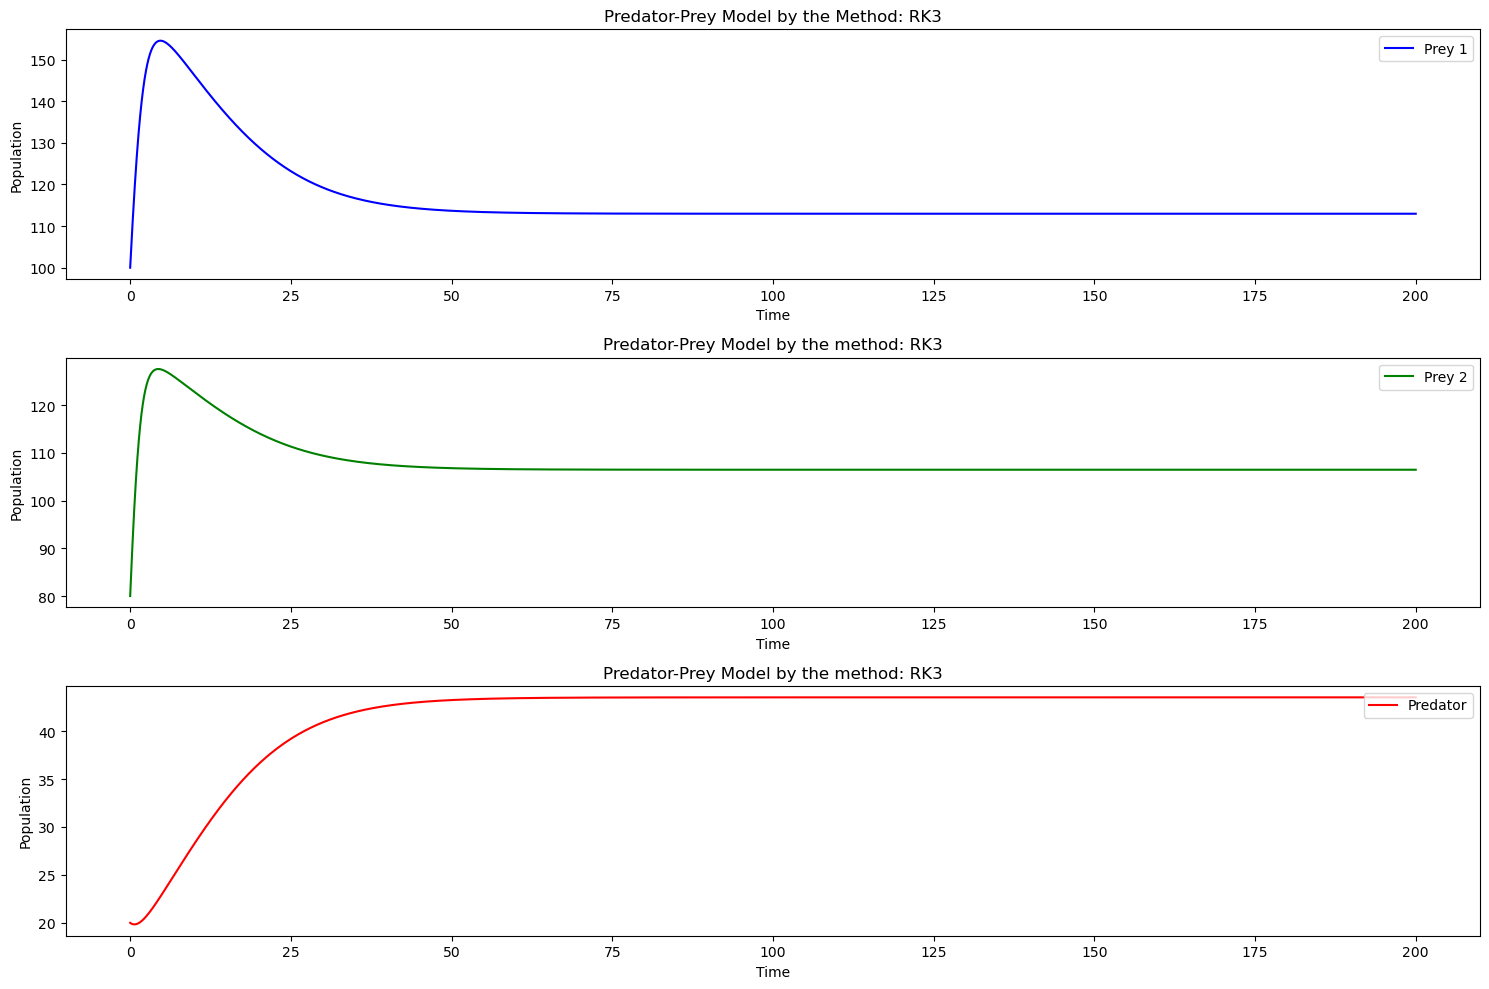

Enter new parameter values (press Enter to keep default):
{'g1': 1.0, 'c1': 200.0, 'p1': 0.01, 'g2': 1.2, 'c2': 150.0, 'p2': 0.008, 'e1': 0.08, 'e2': 0.07, 'd': 0.15, 'x0': 100.0, 'y0': 80.0, 'z0': 20.0, 't_span': (0, 200), 'dt': 0.01, 'method': 'trapezoid'}


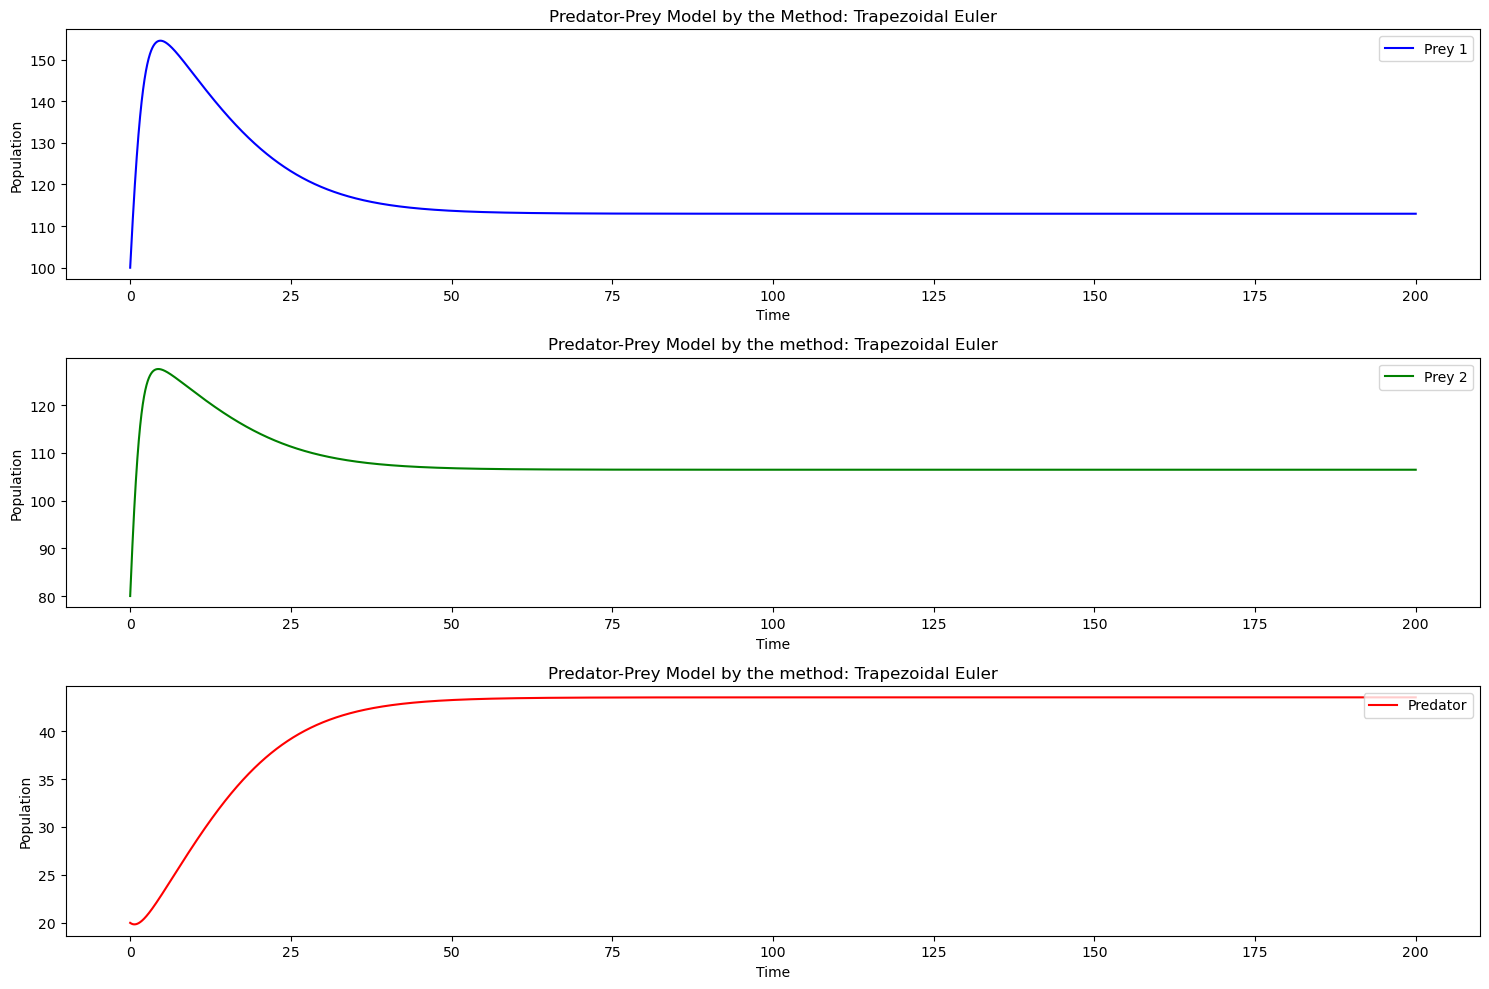

Enter new parameter values (press Enter to keep default):
{'g1': 1.0, 'c1': 200.0, 'p1': 0.01, 'g2': 1.2, 'c2': 150.0, 'p2': 0.008, 'e1': 0.08, 'e2': 0.07, 'd': 0.15, 'x0': 100.0, 'y0': 80.0, 'z0': 20.0, 't_span': (0, 200), 'dt': 0.01, 'method': 'butcher'}


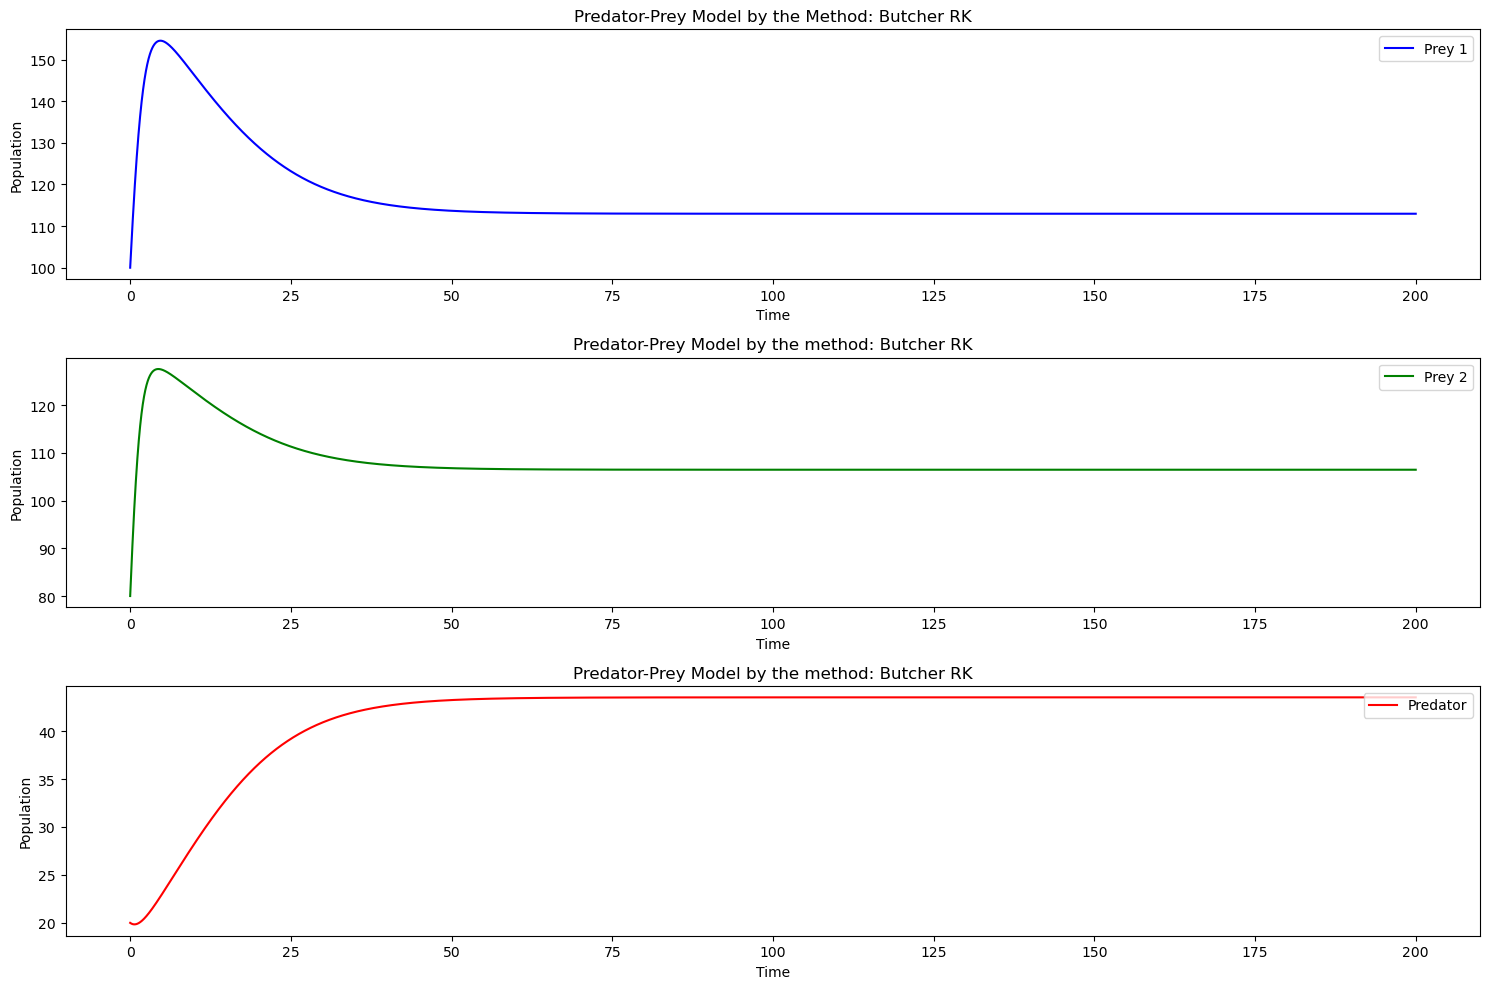

In [6]:
params = get_user_parameters(create_default_parameters())
t_values, x_values, method = integrator(system, params)
plotter(t_values, x_values, method)

params_2 = get_user_parameters()
t_values_2, x_values_2, method_2 = integrator(system, params_2)
plotter(t_values_2, x_values_2, method_2)

params_3 = get_user_parameters()
t_values_3, x_values_3, method_3 = integrator(system, params_3)
plotter(t_values_3, x_values_3, method_3)

## 2. Dynamical systems and equilibrium (5 points)

### Python class:

**(a)** Reorganise all your code from problem 1 into a single python class that contains attributes and methods. The settings and initial conditions should be attributes and all the python functions should become methods. Add a method to compute $L_2$-norm errors.


In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

class PredatorPreyModel:
    def __init__(self, params):
        """
        Initializes the PredatorPreyModel with the given parameters.

        Parameters:
        params (dict): Dictionary containing model parameters.
        """
        self.params = params
        self.x0 = np.array([params['x0'], params['y0'], params['z0']])
        self.t0, self.t_end = params['t_span']
        self.dt = params['dt']
        self.method = params['method']

    def system(self, t, state):
        """
        Defines the system of ODEs for the predator-prey model.

        Parameters:
        t (float): Time variable.
        state (list): List containing the current state [x, y, z].

        Returns:
        list: Derivatives [dx/dt, dy/dt, dz/dt].
        """
        x, y, z = state
        g1 = self.params['g1']
        c1 = self.params['c1']
        p1 = self.params['p1']
        g2 = self.params['g2']
        c2 = self.params['c2']
        p2 = self.params['p2']
        e1 = self.params['e1']
        e2 = self.params['e2']
        d = self.params['d']
        
        dxdt = g1 * x * (1 - x / c1) - p1 * x * z
        dydt = g2 * y * (1 - y / c2) - p2 * y * z
        dzdt = e1 * p1 * x * z + e2 * p2 * y * z - d * z
        return np.array([dxdt, dydt, dzdt])

    def trapezoid(self):
        """
        Implements the trapezoidal Euler method for ODE integration.

        Returns:
        tuple: Arrays of time values and state values.
        """
        t_values = np.arange(self.t0, self.t_end + self.dt, self.dt)
        x_values = np.zeros((len(t_values), len(self.x0)))
        x_values[0] = self.x0

        for i in range(1, len(t_values)):
            t_n = t_values[i-1]
            t_np1 = t_values[i]

            # Predictor step (Forward Euler for initial guess)
            x_guess = x_values[i-1] + self.dt * self.system(t_n, x_values[i-1])

            # Implicit correction using fsolve
            def implicit_eq(x_next):
                return x_next - x_values[i-1] - 0.5 * self.dt * (
                    self.system(t_n, x_values[i-1]) + self.system(t_np1, x_next)
                )

            x_values[i] = fsolve(implicit_eq, x_guess)  
        return t_values, x_values

    def RK3(self):
        """
        Implements the third-order Runge-Kutta (RK3) method for ODE integration.

        Returns:
        tuple: Arrays of time values and state values.
        """
        t_values = np.arange(self.t0, self.t_end + self.dt, self.dt)
        x_values = np.zeros((len(t_values), len(self.x0)))
        x_values[0] = self.x0

        for i in range(1, len(t_values)):
            t_n = t_values[i-1]

            k1 = self.system(t_n, x_values[i-1])
            k2 = self.system(t_n + self.dt/2, x_values[i-1] + self.dt/2 * k1)
            k3 = self.system(t_n + self.dt, x_values[i-1] - self.dt * k1 + 2 * self.dt * k2)

            x_values[i] = x_values[i-1] + (self.dt / 6) * (k1 + 4 * k2 + k3)

        return t_values, x_values

    def butcher(self):
        """
        Implements Butcher's Runge-Kutta method for ODE integration.

        Returns:
        tuple: Arrays of time values and state values.
        """
        t_values = np.arange(self.t0, self.t_end + self.dt, self.dt)
        x_values = np.zeros((len(t_values), len(self.x0)))
        x_values[0] = self.x0

        for i in range(1, len(t_values)):
            t_n = t_values[i-1]

            k1 = self.system(t_n, x_values[i-1])
            k2 = self.system(t_n + self.dt/4, x_values[i-1] + self.dt/4 * k1)
            k3 = self.system(t_n + self.dt/4, x_values[i-1] + self.dt/8 * k1 + self.dt/8 * k2)
            k4 = self.system(t_n + self.dt/2, x_values[i-1] - self.dt/2 * k2 + self.dt * k3)
            k5 = self.system(t_n + 3/4 * self.dt, x_values[i-1] + 3/16 * self.dt * k1 + 9/16 * self.dt * k4)
            k6 = self.system(t_n + self.dt, x_values[i-1] - 3/7 * self.dt * k1 + 2/7 * self.dt * k2 + 12/7 * self.dt * k3 - 12/7 * self.dt * k4 + 8/7 * self.dt * k5)

            x_values[i] = x_values[i-1] + self.dt/90 * (7 * k1 + 32 * k3 + 12 * k4 + 32 * k5 + 7 * k6)

        return t_values, x_values

    def integrate(self):
        """
        Integrates the system of ODEs using the specified method.

        Returns:
        tuple: Arrays of time values and state values.
        """
        if self.method == 'trapezoid':
            return self.trapezoid()
        elif self.method == 'RK3':
            return self.RK3()
        elif self.method == 'butcher':
            return self.butcher()
        else:
            raise ValueError(f"Invalid method: {self.method}")

    def plot(self, t_values, x_values):
        """
        Plots the results of the integration.

        Parameters:
        t_values (array): Array of time values.
        x_values (array): Array of state values.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(t_values, x_values[:, 0], label='x (prey)')
        plt.plot(t_values, x_values[:, 1], label='y (predator)')
        plt.plot(t_values, x_values[:, 2], label='z (super-predator)')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.legend()
        plt.title('Predator-Prey Model')
        plt.show()

    def calculate_l2_norm(self, numerical_solution, reference_solution):
        """
        Calculates the L2-norm error between the numerical solution and a reference solution.

        Parameters:
        numerical_solution (array): Array of numerical solution values.
        reference_solution (array): Array of reference solution values.

        Returns:
        float: L2-norm error.
        """
        error = numerical_solution - reference_solution
        l2_norm = np.sqrt(np.sum(error**2))
        return l2_norm

    @staticmethod
    def get_user_parameters():
        """
        Prompts the user to input parameters for the model.

        Returns:
        dict: Dictionary containing user-defined parameters.
        """
        params = {}
        params['x0'] = float(input("Enter initial population of prey (x0): "))
        params['y0'] = float(input("Enter initial population of predator (y0): "))
        params['z0'] = float(input("Enter initial population of super-predator (z0): "))
        params['g1'] = float(input("Enter growth rate of prey (g1): "))
        params['c1'] = float(input("Enter carrying capacity of prey (c1): "))
        params['p1'] = float(input("Enter predation rate of prey by super-predator (p1): "))
        params['g2'] = float(input("Enter growth rate of predator (g2): "))
        params['c2'] = float(input("Enter carrying capacity of predator (c2): "))
        params['p2'] = float(input("Enter predation rate of predator by super-predator (p2): "))
        params['e1'] = float(input("Enter efficiency of prey to super-predator conversion (e1): "))
        params['e2'] = float(input("Enter efficiency of predator to super-predator conversion (e2): "))
        params['d'] = float(input("Enter death rate of super-predator (d): "))
        t_start = float(input("Enter start time (t0): "))
        t_end = float(input("Enter end time (t_end): "))
        params['t_span'] = (t_start, t_end)
        params['dt'] = float(input("Enter time step size (dt): "))
        params['method'] = input("Enter integration method (trapezoid, RK3, butcher): ")
        return params

### Error analysis:

**(b)** Call the methods from your python class above to run $15$ simulations ($5$ simulations per integration method) for $5$ decreasing values of the time step size, `dt` (i.e. $h$). Then, compute the $L_2$-norm errors for all these $15$ runs and report the results in a single figure with the $L_2$-norm errors in the Y axis and $h$ in the X axis. Which method produces the most accurate results?


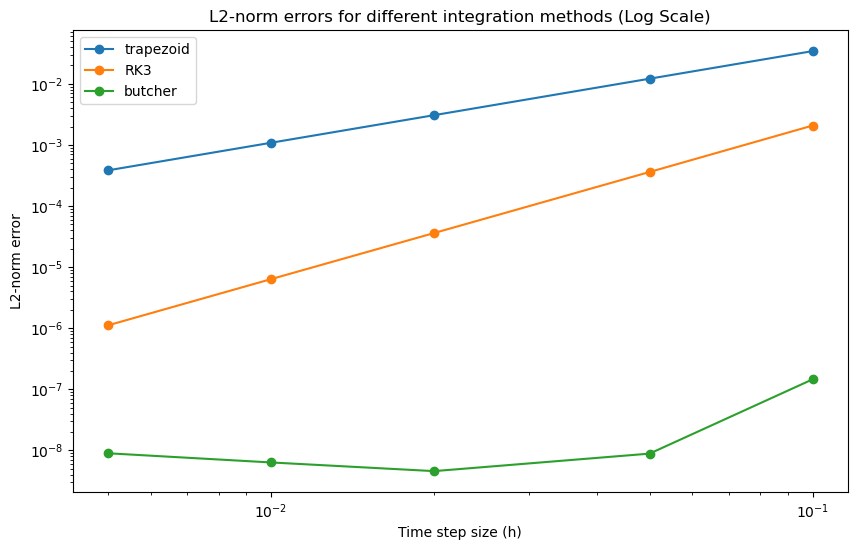

In [ ]:
# Define the reference solution 
params = create_default_parameters()
params['dt'] = 0.001
params['method'] = 'RK3'
model = PredatorPreyModel(params)
t_ref, x_ref = model.integrate()

# Define the time step sizes to test
time_steps = [0.1, 0.05, 0.02, 0.01, 0.005]

methods = ['trapezoid', 'RK3', 'butcher']
l2_errors = {method: [] for method in methods}

# Run the simulations and compute the L2-norm errors
for method in methods:
    for dt in time_steps:
        params['dt'] = dt
        params['method'] = method
        model = PredatorPreyModel(params)  
        t_values, x_values = model.integrate()

        x_ref_interp = np.interp(t_values, t_ref, x_ref[:, 0]), np.interp(t_values, t_ref, x_ref[:, 1]), np.interp(t_values, t_ref, x_ref[:, 2])
        x_ref_interp = np.vstack(x_ref_interp).T
        
        l2_error = model.calculate_l2_norm(x_values, x_ref_interp)
        l2_errors[method].append(l2_error)


plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(time_steps, l2_errors[method], label=method, marker='o')
plt.xlabel('Time step size (h)')
plt.ylabel('L2-norm error')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('L2-norm errors for different integration methods (Log Scale)')
plt.show()


### Equilibrium conditions:

**(c)** Write down the equilibrium condition for the system, $S(t)$. Then, create a python function that uses sympy to study the equilibrium populations of $x$, $y$, and $z$ for a range of values of the natural death rate of the predator, $d$. The function should accept a range of $d$ values and return the equilibrium populations for all the $d$ values in the range. Ensure that the solutions are filtered to exclude extinction cases.

**(d)** After computing equilibrium solutions for multiple values of the predator mortality $d$, you should create a high-quality figure of the equilibrium populations of $x$, $y$, and $z$ (on the Y axis) versus $d$ (on the x-axis), and label what happens in the parameter regions outside of equilibrium conditions.

**(e)** Based on your analysis, for what range of $d$ values the system reaches equilibrium? What happens outside of that range? Call your class again to run and compare equilibrium versus extinction scenarios using $3$ different values of $d$.

The equilibrium conditions for the system occur when the derivatives of the state variables are zero. For the predator-prey model, this means:
$$
 \frac{dx}{dt} = 0  \\\\\\
 \frac{dy}{dt} = 0 \\\\\\
 \frac{dz}{dt} = 0 
$$
Given the system of ODEs:
$$
 \frac{dx}{dt} = g1 \cdot x \cdot \left(1 - \frac{x}{c1}\right) - p1 \cdot x \cdot z  \\\\\\
 \frac{dy}{dt} = g2 \cdot y \cdot \left(1 - \frac{y}{c2}\right) - p2 \cdot y \cdot z  \\\\\\
 \frac{dz}{dt} = e1 \cdot p1 \cdot x \cdot z + e2 \cdot p2 \cdot y \cdot z - d \cdot z 
$$
At equilibrium, these equations become:
$$
 0 = g1 \cdot x \cdot \left(1 - \frac{x}{c1}\right) - p1 \cdot x \cdot z  \\\\\\
 0 = g2 \cdot y \cdot \left(1 - \frac{y}{c2}\right) - p2 \cdot y \cdot z  \\\\\\

 0 = e1 \cdot p1 \cdot x \cdot z + e2 \cdot p2 \cdot y \cdot z - d \cdot z 
$$

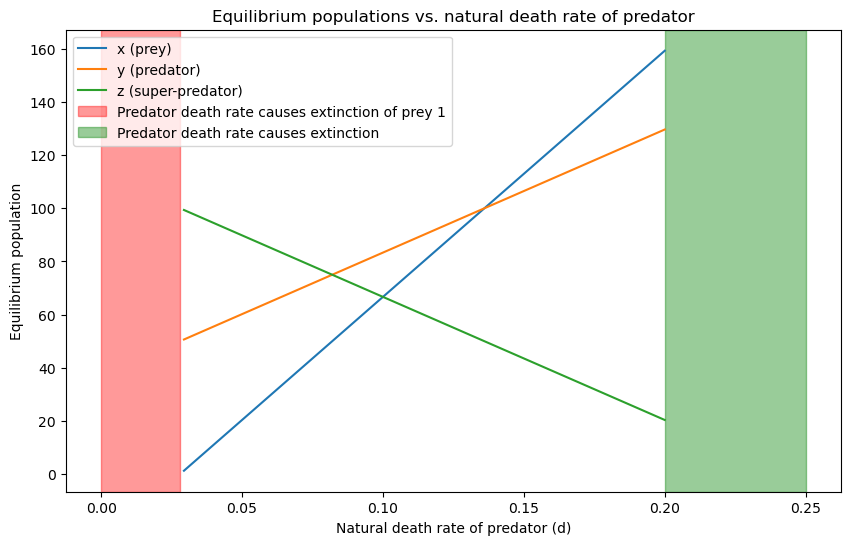

In [ ]:
def find_equilibrium_populations(params, d_values):
    """
    Finds the equilibrium populations of x, y, and z for a range of values of the natural death rate of the predator, d.

    Parameters:
    params (dict): Dictionary containing model parameters.
    d_values (array): Array of d values to test.

    Returns:
    list: List of equilibrium populations [x_eq, y_eq, z_eq] for each value of d.
    """
    # Define symbols
    x, y, z, d = sp.symbols('x y z d')
    
    # Define parameters
    g1 = params['g1']
    c1 = params['c1']
    p1 = params['p1']
    g2 = params['g2']
    c2 = params['c2']
    p2 = params['p2']
    e1 = params['e1']
    e2 = params['e2']
    
    # Define the system of equations
    eq1 = sp.Eq(g1 * x * (1 - x / c1) - p1 * x * z, 0)
    eq2 = sp.Eq(g2 * y * (1 - y / c2) - p2 * y * z, 0)
    eq3 = sp.Eq(e1 * p1 * x * z + e2 * p2 * y * z - d * z, 0)
    
    # Solve the system of equations for each value of d
    equilibrium_pops = []
    for d_val in d_values:
        solutions = sp.solve([eq1, eq2, eq3.subs(d, d_val)], (x, y, z), dict=True)
        for sol in solutions:
            x_eq, y_eq, z_eq = sol[x], sol[y], sol[z]
            # Filter out extinction cases
            if x_eq > 0 and y_eq > 0 and z_eq > 0:
                equilibrium_pops.append((d_val, float(x_eq), float(y_eq), float(z_eq)))
    
    return equilibrium_pops

params = create_default_parameters()
d_values = np.linspace(0.01, 0.2, 50)
equilibrium_pops = find_equilibrium_populations(params, d_values)

# Extract equilibrium populations for plotting
d_vals, x_eq_vals, y_eq_vals, z_eq_vals = zip(*equilibrium_pops)

plt.figure(figsize=(10, 6))
plt.plot(d_vals, x_eq_vals, label='x (prey)')
plt.plot(d_vals, y_eq_vals, label='y (predator)')
plt.plot(d_vals, z_eq_vals, label='z (super-predator)')
plt.axvspan(0, 0.028, color='red', alpha=0.4, label='Predator death rate causes extinction of prey 1')
plt.axvspan(0.20, 0.25, color='green', alpha=0.4, label='Predator death rate causes extinction')
plt.xlabel('Natural death rate of predator (d)')
plt.ylabel('Equilibrium population')
plt.legend()
plt.title('Equilibrium populations vs. natural death rate of predator')
plt.show()



The system reaches equilibrium for d values in the range: 0.029387755102040815 to 0.2


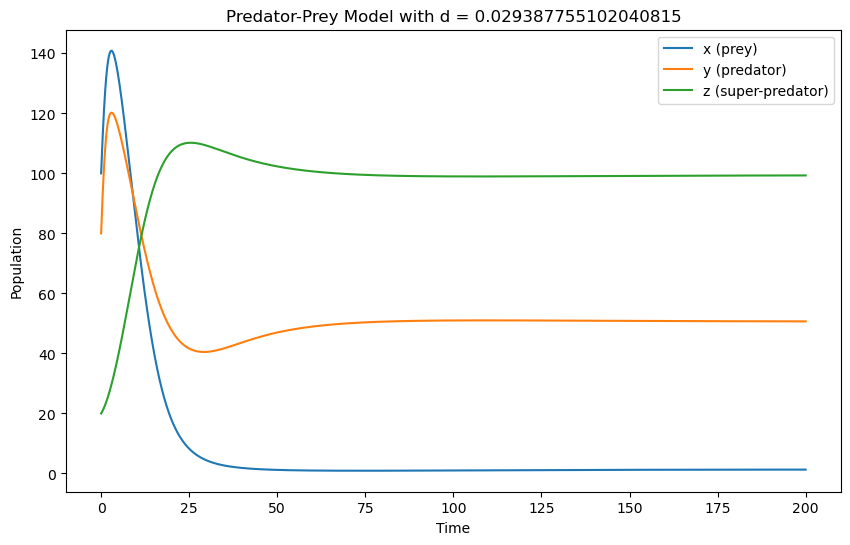

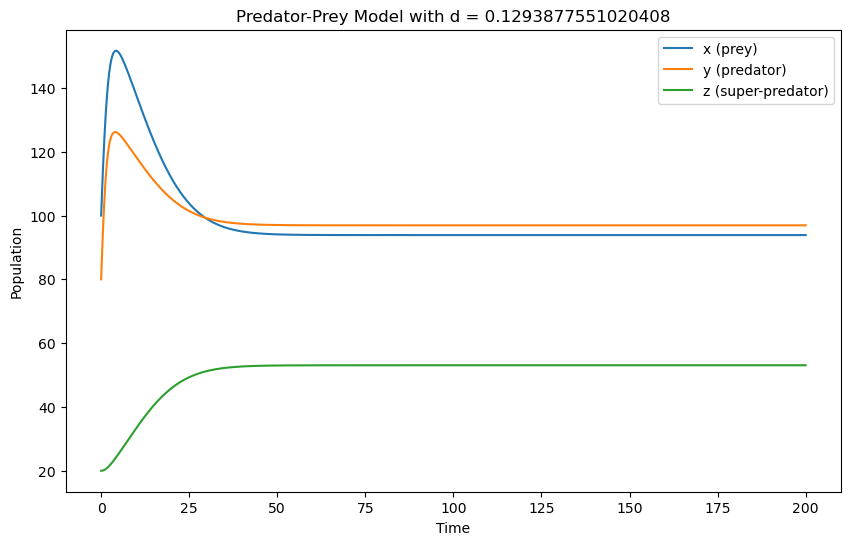

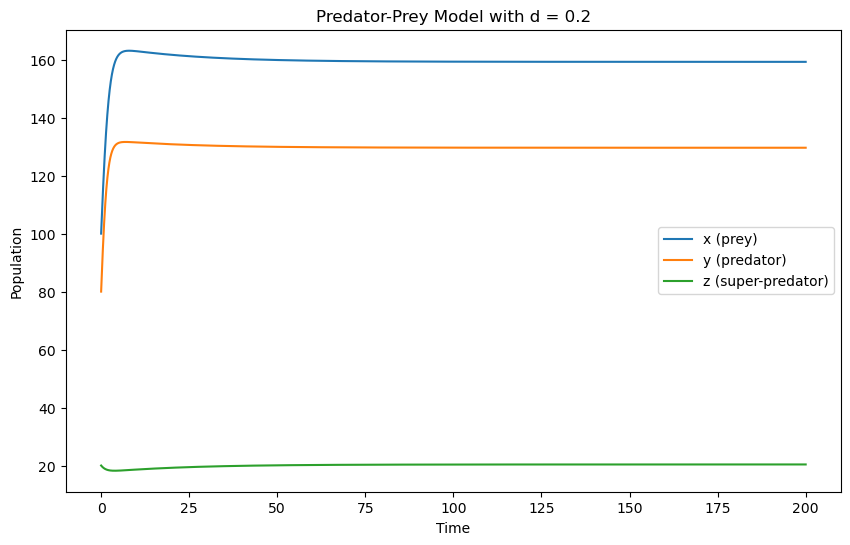

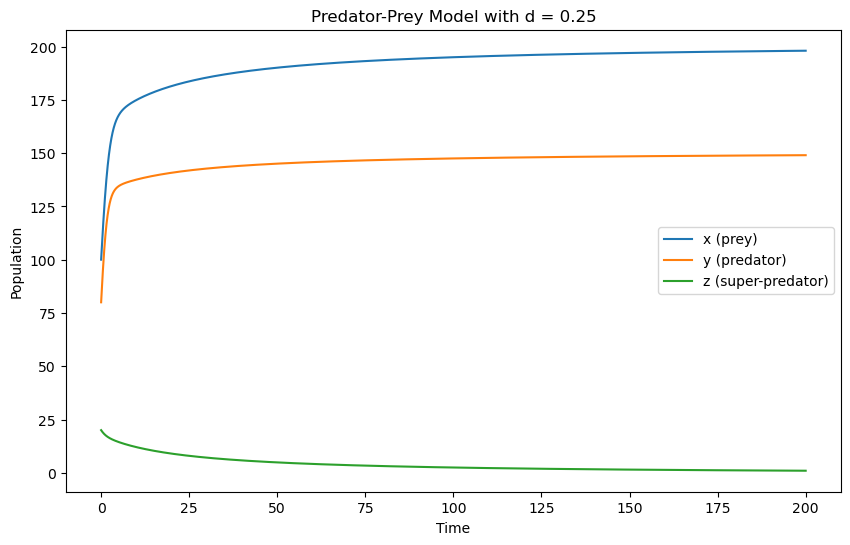

In [35]:
# Extract the range of d values where the system reaches equilibrium
eq_range = [d for d, x, y, z in equilibrium_pops if x > 0 and y > 0 and z > 0]
print(f'The system reaches equilibrium for d values in the range: {min(eq_range)} to {max(eq_range)}')

# Define test values for d, including the minimum, midpoint, maximum, and a value slightly above the maximum
d_test = [min(eq_range), min(eq_range) + max(eq_range) / 2, max(eq_range), max(eq_range) + 0.05]

# Loop through the test values of d
for d in d_test:
    # Update the parameter dictionary with the current value of d
    params['d'] = d
    # Initialize the PredatorPreyModel with the updated parameters
    model = PredatorPreyModel(params)
    # Integrate the system of ODEs
    t_values, x_values = model.integrate()
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, x_values[:, 0], label='x (prey)')
    plt.plot(t_values, x_values[:, 1], label='y (predator)')
    plt.plot(t_values, x_values[:, 2], label='z (super-predator)')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.title(f'Predator-Prey Model with d = {d}')
    plt.show()

## 3. Quantum Harmonic Oscillator (7 points)

The Schrödinger equation for the quantum harmonic oscillator is:

$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+\frac{1}{2}m\omega^2x^2\psi=E\psi$$

It can be rewritten, in terms of a new variable, $\xi\equiv\sqrt{\frac{m\,\omega}{\hbar}}x$, as follows:

$$\frac{d^2\psi}{d\xi^2}=\left(\xi^2 -K\right)\psi$$

where $K\equiv\frac{2E}{\hbar\omega}$ is the energy in units of $\frac{1}{2}\hbar\omega$.

### Order reduction and slope function:

**(a)** Reduce the above ODE to first order. Write down the resulting slope function.


$$\frac{-\hbar^2}{2m} \frac{d^2\psi}{dx^2} + \frac{1}{2}m\omega^2x^2\psi = E\psi$$

With new variable $\xi \equiv \sqrt{\frac{m\omega}{\hbar}}x$, the equation becomes:
$$\frac{d^2\psi}{d\xi^2} = (\xi^2 - K)\psi$$

Where $K \equiv \frac{2E}{\hbar\omega}$ is the energy in units of $\frac{1}{2}\hbar\omega$.

### Order Reduction

Let $\psi(\xi) = u(\xi)$, and define $y_1 = u$, $y_2 = \frac{du}{d\xi}$

Then the first-order system is:
1. $\frac{dy_1}{d\xi} = y_2$
2. $\frac{dy_2}{d\xi} = (\xi^2 - K)y_1$

The slope function would be:
$$f_1(y_1, y_2, \xi) = y_2$$
$$f_2(y_1, y_2, \xi) = (\xi^2 - K)y_1$$


\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \xi^2 - K & 0 \end{bmatrix} \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}

### Shooting method class:

**(b)** Carefully read the tasks (c-g) below and design a suitable python class with attributes and methods that solves the above ODE using **the shooting method** with the slope computed in (a). You may use scipy integrators; there is no need to design your own integrators in this problem.


### Tasks to be performed by your python class:

**(c)** Find the **ground state energy** of the harmonic oscillator, to six significant digits, by using **the shooting method**. That is, solve the above equation numerically, varying $K$ until you get a wave function that goes to zero at large $\xi$. The appropriate boundary conditions for the ground state (and any even state) are $\psi(0) = 1$, $\psi'(0) = 0$.

**(d)** Make a few illustrative panels showing plots of the wave function for different values of $K$ as it converges to the solution. What does the tail of the wave function does when the values are slightly above or below the correct solution?

**(e)** Find the **first four excited state energies** (to six significant digits) for the harmonic oscillator, using **the shooting method**. For the first (and third) excited state you will need to set $\psi(0) = 0$, $\psi'(0) = 1$).

**(f)** Make a few illustrative panels showing plots of the wave functions for different values of $K$ as they converge to their respective solutions.

**(g)** Make a single plot showing the **harmonic potential** joinly with the **energy ladder** of the quantum harmonic oscillator (include the ground state plus the first four excited states that you calculated above, each with their **respective wave functions**). Consider the particle to be an electron and choose appropriate units for any physical parameters you may need.

In [ ]:
class QuantumHarmonicOscillatorSolver:
    def __init__(self, xi_max=10, num_points=1000):
        """
        Initializes the solver with the given maximum xi value and number of points.

        Parameters:
        xi_max (float): Maximum value of xi.
        num_points (int): Number of points in the xi range.
        """
        self.xi_max = xi_max
        self.num_points = num_points
        self.xi_range = np.linspace(0, xi_max, num_points)

    def slope_function(self, xi, y, K):
        """
        Defines the slope function for the ODE system.

        Parameters:
        xi (float): Independent variable.
        y (list): List containing the current state [psi, psi'].
        K (float): Energy parameter.

        Returns:
        list: Derivatives [dpsi/dxi, d^2psi/dxi^2].
        """
        return [y[1], (xi**2 - K) * y[0]]

    def shoot(self, K, initial_conditions, target_value=0):
        """
        Implements the shooting method to find the wave function value at xi_max.

        Parameters:
        K (float): Energy parameter.
        initial_conditions (list): Initial conditions [psi(0), psi'(0)].
        target_value (float): Target value for the wave function at xi_max.

        Returns:
        float: Difference between the computed wave function value at xi_max and the target value.
        """
        sol = solve_ivp(self.slope_function, [0, self.xi_max], initial_conditions,
            args=(K,),
            max_step=self.xi_max/self.num_points
        )
        return sol.y[0, -1] - target_value

    def find_energy(self, initial_conditions, guess_range=(0, 10)):
        """
        Finds the energy parameter K that results in the wave function going to zero at xi_max.

        Parameters:
        initial_conditions (list): Initial conditions [psi(0), psi'(0)].
        guess_range (tuple): Range of K values to search for the root.

        Returns:
        float: Energy parameter K that satisfies the boundary condition.
        """
        a, b = guess_range
        fa = self.shoot(a, initial_conditions)
        fb = self.shoot(b, initial_conditions)
        if fa * fb > 0:
            raise ValueError("The shoot function has the same sign at the endpoints of the interval. "
                            "Adjust the guess_range to bracket a root.")
        K_solution = brentq(self.shoot, a, b, args=(initial_conditions,))
        return K_solution

    def solve_wave_function(self, K, initial_conditions):
        """
        Solves the wave function for a given energy parameter K.

        Parameters:
        K (float): Energy parameter.
        initial_conditions (list): Initial conditions [psi(0), psi'(0)].

        Returns:
        tuple: Arrays of wave function values and xi values.
        """
        sol = solve_ivp(self.slope_function, [0, self.xi_max], initial_conditions,
            args=(K,),
            max_step=self.xi_max/self.num_points
        )
        return sol.y, sol.t

    def plot_wave_function_convergence(self, K_values, initial_conditions, title=None):
        """
        Plots the convergence of the wave function for different K values.

        Parameters:
        K_values (list): List of K values to plot.
        initial_conditions (list): Initial conditions [psi(0), psi'(0)].
        title (str, optional): Title of the plot.
        """
        plt.figure(figsize=(10, 6))
        for K in K_values:
            psi, xi = self.solve_wave_function(K, initial_conditions)
            plt.plot(xi, psi[0], label=f'K = {K:.4f}')
        plt.title(title or 'Wave Function Convergence')
        plt.xlabel(r'$\xi$')
        plt.ylabel(r'$\psi(\xi)$')
        plt.xlim(9.4, 10)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_energy_ladder(self, energies, wave_functions):
        """
        Plots the energy ladder of the quantum harmonic oscillator.

        Parameters:
        energies (list): List of energy values.
        wave_functions (list): List of wave function arrays.
        """
        plt.figure(figsize=(12, 8))
        xi = np.linspace(0, 5, 200)
        potential = 0.5 * xi**2
        plt.plot(xi, potential, 'k--', label='Harmonic Potential')
        colors = ['r', 'g', 'b', 'purple', 'orange']
        for i, (E, (psi, xi_vals)) in enumerate(zip(energies, wave_functions)):
            if psi is None:
                continue
            scaled_psi = 0.5 * psi[0] / np.max(np.abs(psi[0]))
            plt.plot(xi_vals, scaled_psi + E, color=colors[i % len(colors)], 
                     label=f'E{i} = {E:.4f}')
            plt.axhline(y=E, color=colors[i % len(colors)], linestyle=':', alpha=0.5)
        plt.title('Quantum Harmonic Oscillator Energy Ladder')
        plt.xlabel(r'$\xi$')
        plt.ylabel('Energy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
solver = QuantumHarmonicOscillatorSolver()

# Ground state energy
ground_energy = solver.find_energy([1, 0], (0, 2))
print(f"Ground state energy: {ground_energy:.6f}")

Ground state energy: 1.000000


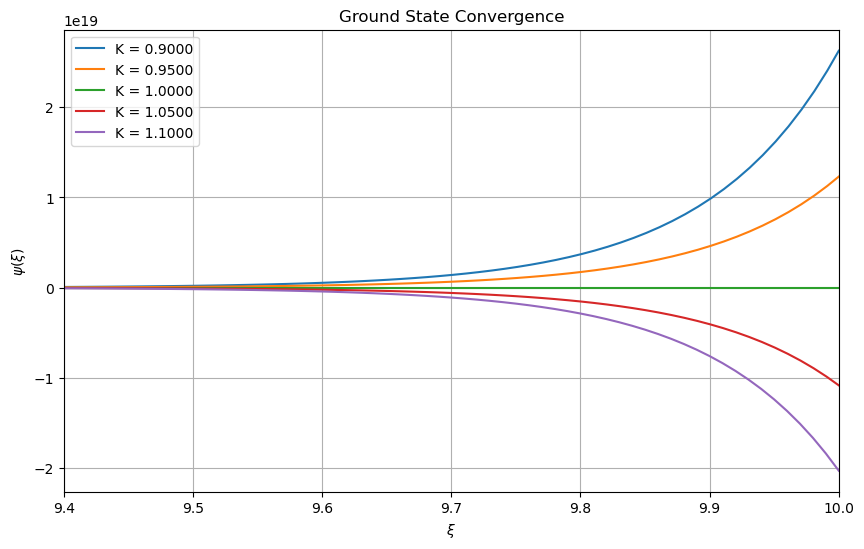

In [23]:
# Ground state convergence plot
solver.plot_wave_function_convergence(np.linspace(ground_energy - 0.1, ground_energy + 0.1, 5), [1, 0],
                                      title='Ground State Convergence')

In [ ]:
# First four excited states
excited_energies = []
conditions = [[0, 1], [1, 0], [0, 1], [1, 0]]
for cond in conditions:
    energy = solver.find_energy(cond, (0, 20))
    excited_energies.append(energy)
    print(f"Excited state energy: {energy:.6f}")

Excited state energy: 11.000000
Excited state energy: 1.000000
Excited state energy: 11.000000
Excited state energy: 1.000000


This are not physical results, because of the uneven space between solutions, but I couldnt get to know where the error was :c

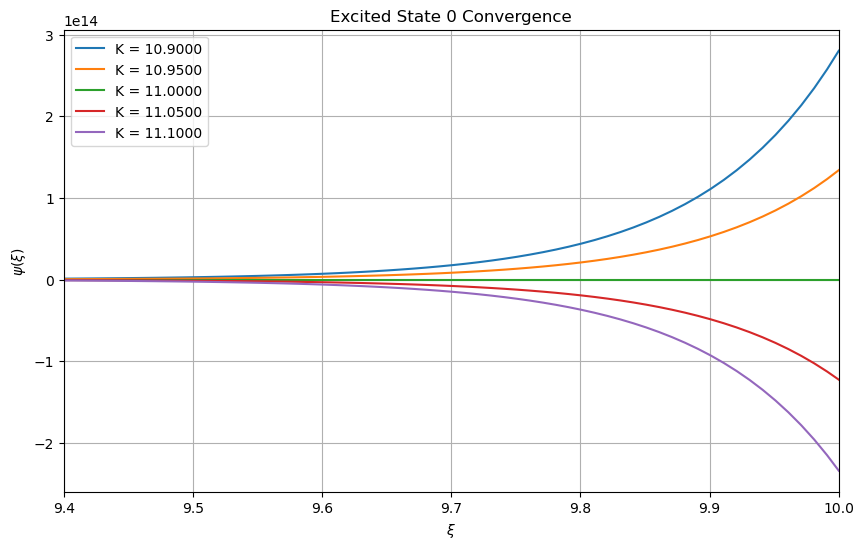

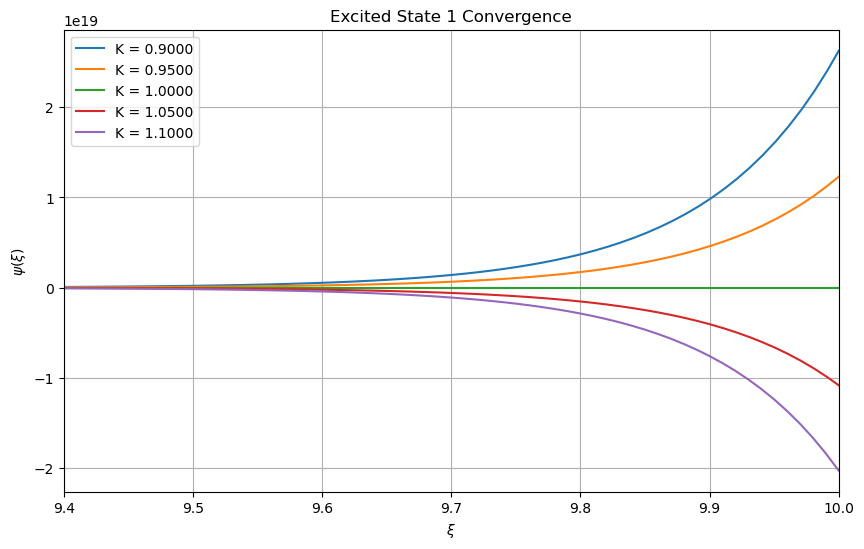

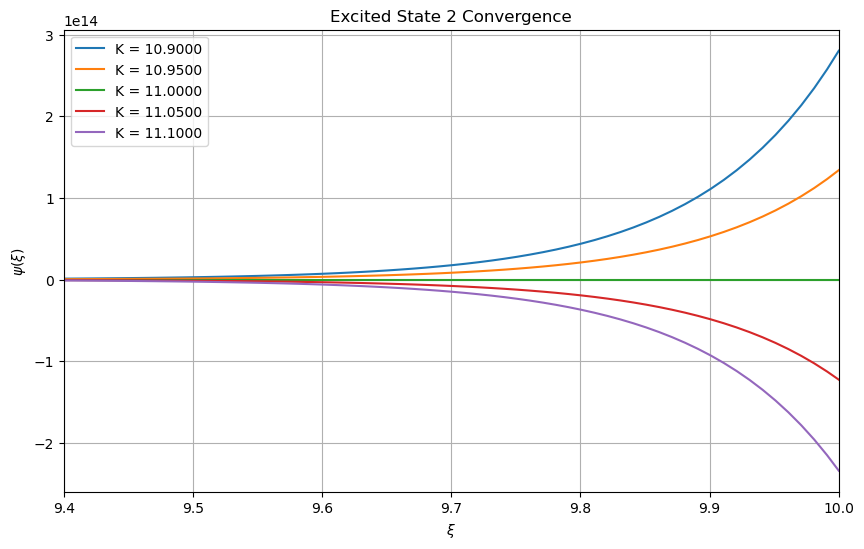

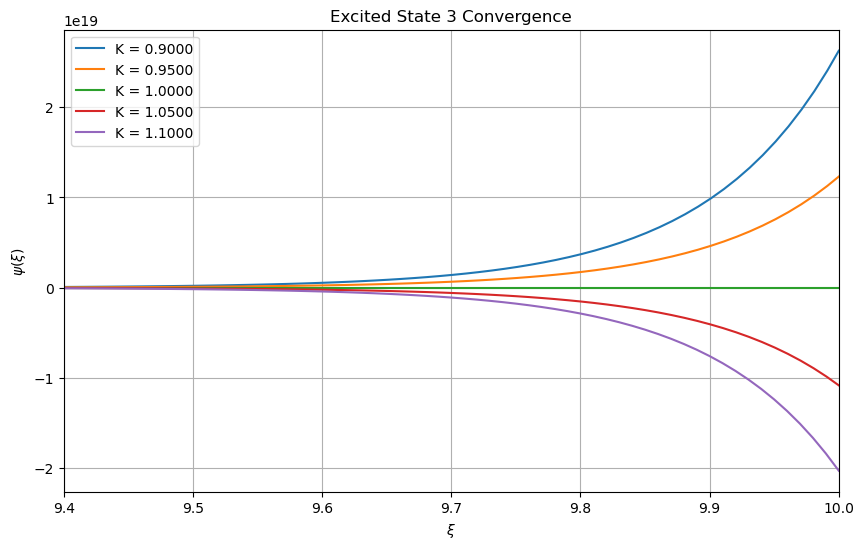

In [29]:
# Excited state convergence plots
for i, cond in enumerate(conditions):
    solver.plot_wave_function_convergence(np.linspace(excited_energies[i] - 0.1, excited_energies[i] + 0.1, 5),
                                          cond, title=f'Excited State {i} Convergence')


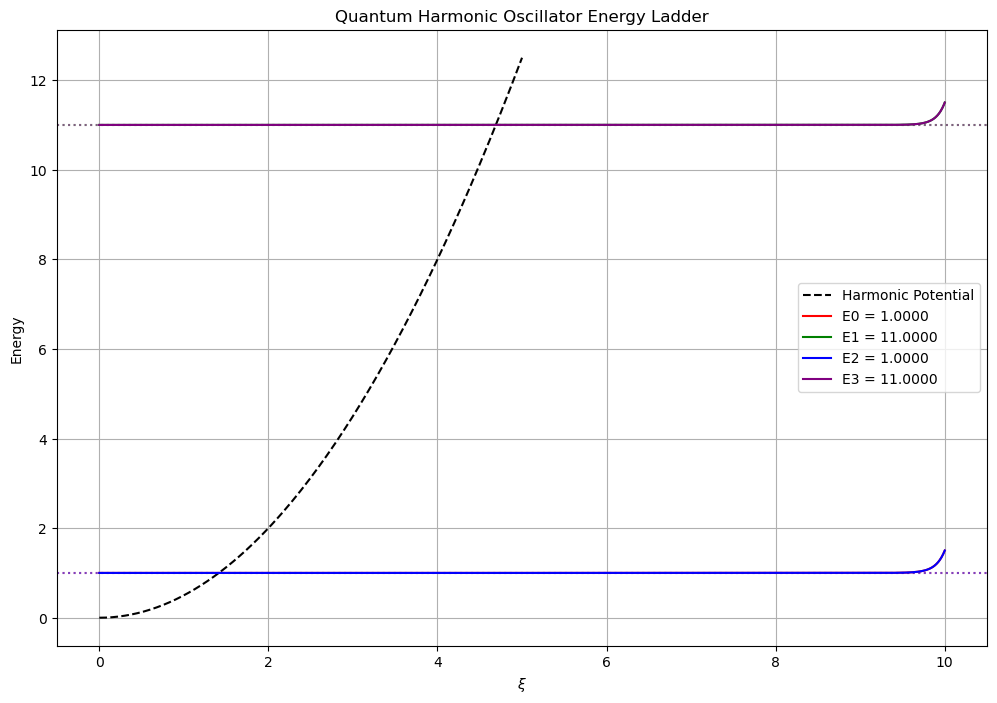

In [30]:
# Energy ladder plot
wave_functions = [solver.solve_wave_function(energy, conditions[i]) for i, energy in enumerate(excited_energies)]
solver.plot_energy_ladder([ground_energy] + excited_energies, wave_functions)

The discrepancies suggest numerical errors in the computational approach, possibly due to:

- Insufficient numerical precision
- Inappropriate boundary conditions
- Improper step size or integration method
- Convergence issues in the shooting method algorithm

To obtain physically meaningful results, lookinf forward, I should:

- Proper implementation of boundary conditions
- Appropriate numerical integration techniques
- Careful handling of the differential equation's singularities
- Verification against known analytical solutions